In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Preprocessed_GHED.xlsx to Preprocessed_GHED.xlsx


In [5]:
import pandas as pd

# File path for the uploaded file
file_path = '/content/Preprocessed_GHED.xlsx'

try:
    df = pd.read_excel(file_path)
    print("File loaded successfully!")
    print(df.head())  # Display the first few rows of the dataframe
except FileNotFoundError:
    print(f"File not found at: {file_path}. Ensure the file is uploaded.")

File loaded successfully!
    Country Income  Year  Out of Pocket Expense   oops_che   ext_che  \
0  Ethiopia    Low  2012                    42.2        9.0     27.9   
1  Ethiopia    Low  2013                    42.4        8.0     23.3   
2  Ethiopia    Low  2014                    38.5        8.0     23.4   
3  Ethiopia    Low  2015                    36.7        9.0     18.3   
4  Ethiopia    Low  2016                    35.4        9.0     20.2   

   dis1_che  dis11_che   dis4_che  dis5_che  disnec_che      gdp  che_gdp  \
0       NaN         NaN       NaN       NaN         NaN   747326      4.5   
1       NaN         NaN       NaN       NaN         NaN   866921      4.1   
2       NaN         NaN       NaN       NaN         NaN  1060825      4.0   
3       NaN         NaN       NaN       NaN         NaN  1297961      3.8   
4       NaN         NaN       NaN       NaN         NaN  1568097      3.6   

   che_pc_usd    gghed     pvtd  dom_che  shise_shi  
0          20   7971.0  

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Handle missing values
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

non_numeric_cols = df.select_dtypes(include=['object']).columns
df[non_numeric_cols] = df[non_numeric_cols].fillna("Unknown")

# Encode categorical variables while retaining the original names
label_encoders = {}
country_name_mapping = {}
for col in ['Country', 'Income']:
    label_encoders[col] = LabelEncoder()
    df[col + '_Encoded'] = label_encoders[col].fit_transform(df[col])  # Create encoded columns
    if col == 'Country':
        country_name_mapping = dict(zip(df[col + '_Encoded'], df[col]))

# Save the preprocessed dataset
cleaned_file_path = "/content/Cleaned_Preprocessed_GHED.xlsx"
df.to_excel(cleaned_file_path, index=False)
print(f"Cleaned data saved at: {cleaned_file_path}")

Cleaned data saved at: /content/Cleaned_Preprocessed_GHED.xlsx


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd

# Feature and target selection
features = ['Year', 'Income_Encoded']  # Use encoded columns for numeric processing
targets = ['che_gdp', 'Out of Pocket Expense ']  # Columns to predict

# Initialize results
all_predictions = pd.DataFrame()

# Iterate over unique country codes
for country_code, country_name in country_name_mapping.items():
    print(f"Processing for country: {country_name}")

    # Filter data for the country
    country_df = df[df['Country_Encoded'] == country_code]

    if len(country_df) < 2:  # Skip if not enough data for training
        print(f"Not enough data for {country_name}. Skipping.")
        continue

    # Split data into features and targets
    X = country_df[features]
    y = country_df[targets]

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Random Forest model
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error for {country_name}: {mse}")

    # Predict only for 2025 for this country
    future_years = pd.DataFrame({
        'Year': [2025],  # Predict for the year 2025 only
        'Income_Encoded': [country_df['Income_Encoded'].iloc[0]]
    })

    future_predictions = rf_model.predict(future_years)
    future_years['che_gdp'] = future_predictions[:, 0]
    future_years['Out of Pocket Expense '] = future_predictions[:, 1]
    future_years['Country'] = country_name  # Explicitly add country name

    # Append to results
    all_predictions = pd.concat([all_predictions, future_years])

# Reset index for final predictions
all_predictions.reset_index(drop=True, inplace=True)

# Display predictions
print("Future Predictions for the Year 2025 for All Countries:")
print(all_predictions)

# Save predictions to Excel
all_predictions.to_excel("/content/Future_Predictions_For_2025.xlsx", index=False)
print("Predictions saved as 'Future_Predictions_For_2025.xlsx'.")

Processing for country: Ethiopia
Mean Squared Error for Ethiopia: 5.3525857500001175
Processing for country: Rwanda
Mean Squared Error for Rwanda: 1.3969612499999948
Processing for country: South Africa
Mean Squared Error for South Africa: 0.129470749999996
Processing for country: Brazil
Mean Squared Error for Brazil: 0.7985562500000073
Processing for country: Canada
Mean Squared Error for Canada: 0.04815383333333541
Processing for country: Mexico
Mean Squared Error for Mexico: 2.9512585000001184
Processing for country: United States of America
Mean Squared Error for United States of America: 1.346111362622985
Processing for country: Saudi Arabia
Mean Squared Error for Saudi Arabia: 0.7872557500000044
Processing for country: Germany
Mean Squared Error for Germany: 1.7826084707907786
Processing for country: United Kingdom of Great Britain and Northern Ireland
Mean Squared Error for United Kingdom of Great Britain and Northern Ireland: 1.430672555779692
Processing for country: India
Mean

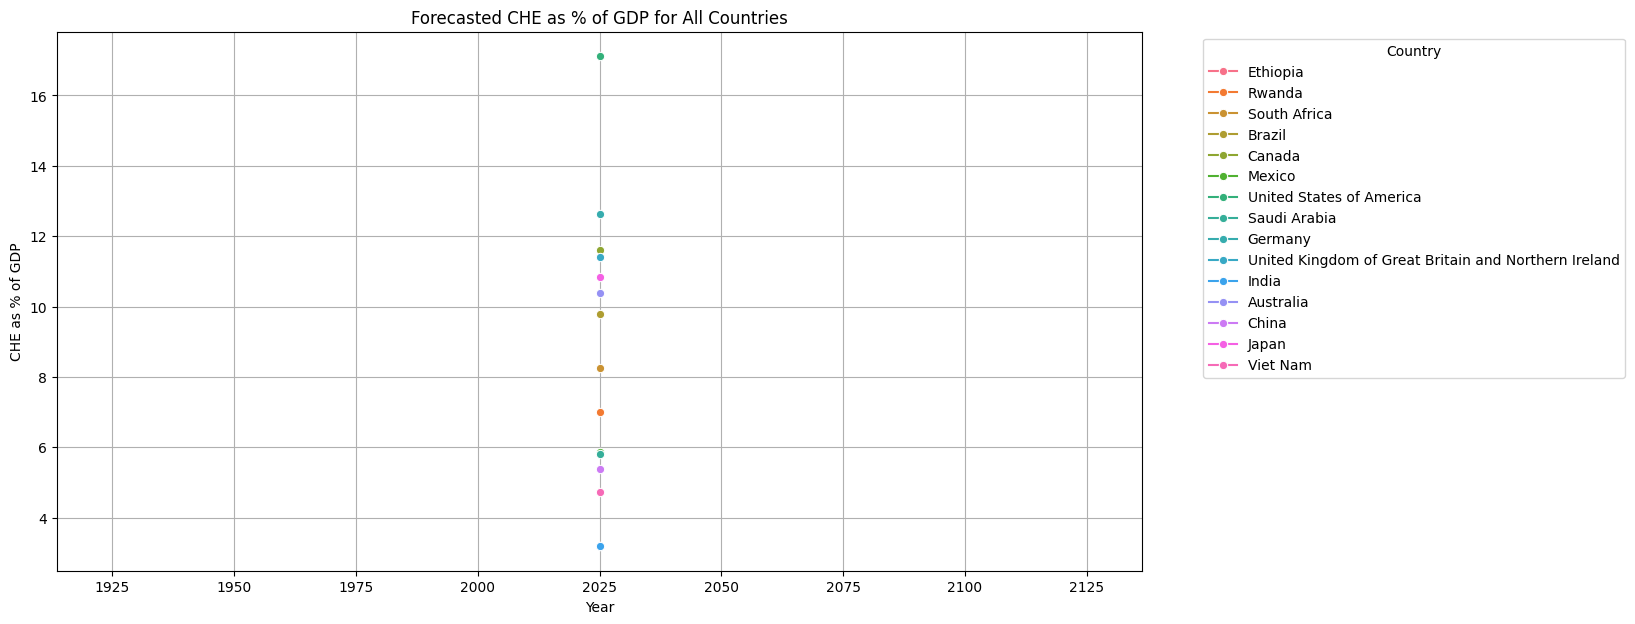

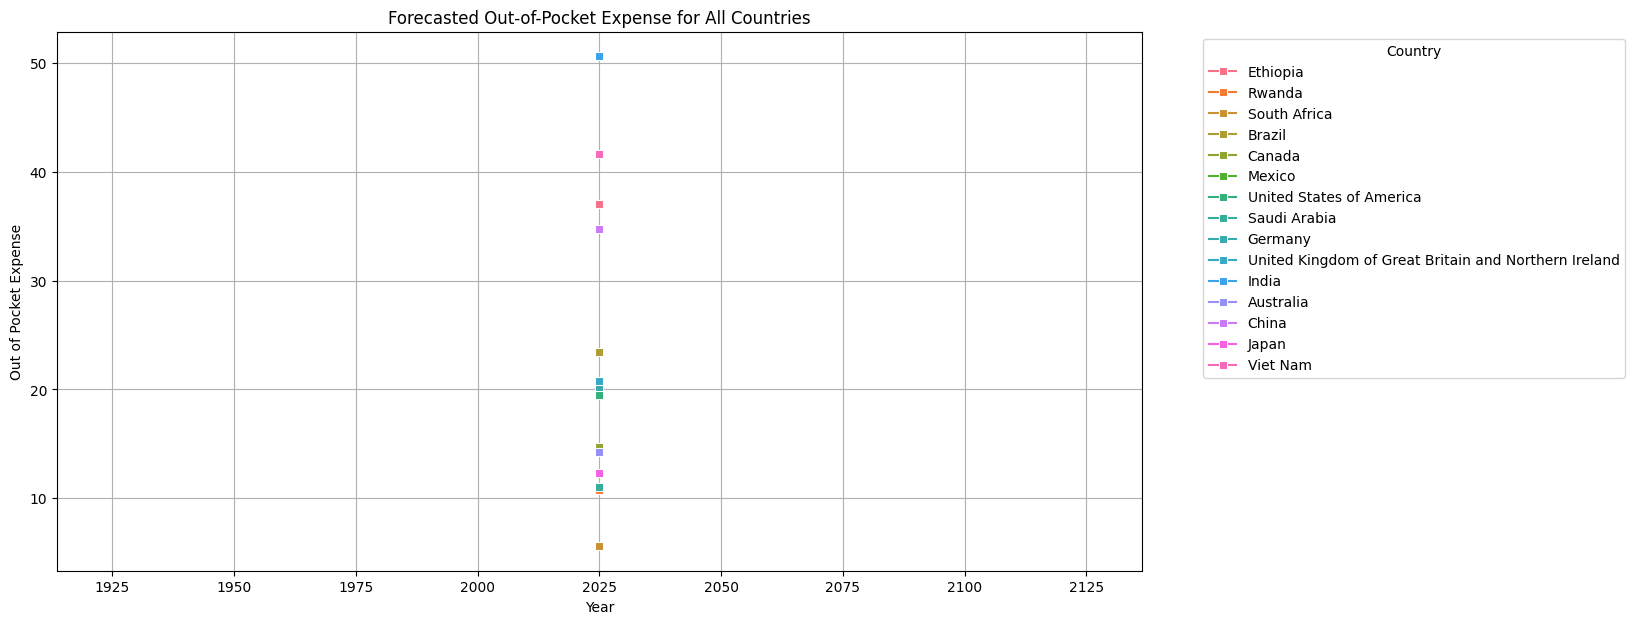

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization for CHE as % of GDP
plt.figure(figsize=(14, 7))
sns.lineplot(data=all_predictions, x='Year', y='che_gdp', hue='Country', marker='o')
plt.title('Forecasted CHE as % of GDP for All Countries')
plt.xlabel('Year')
plt.ylabel('CHE as % of GDP')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

# Visualization for Out-of-Pocket Expense
plt.figure(figsize=(14, 7))
sns.lineplot(data=all_predictions, x='Year', y='Out of Pocket Expense ', hue='Country', marker='s')
plt.title('Forecasted Out-of-Pocket Expense for All Countries')
plt.xlabel('Year')
plt.ylabel('Out of Pocket Expense')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

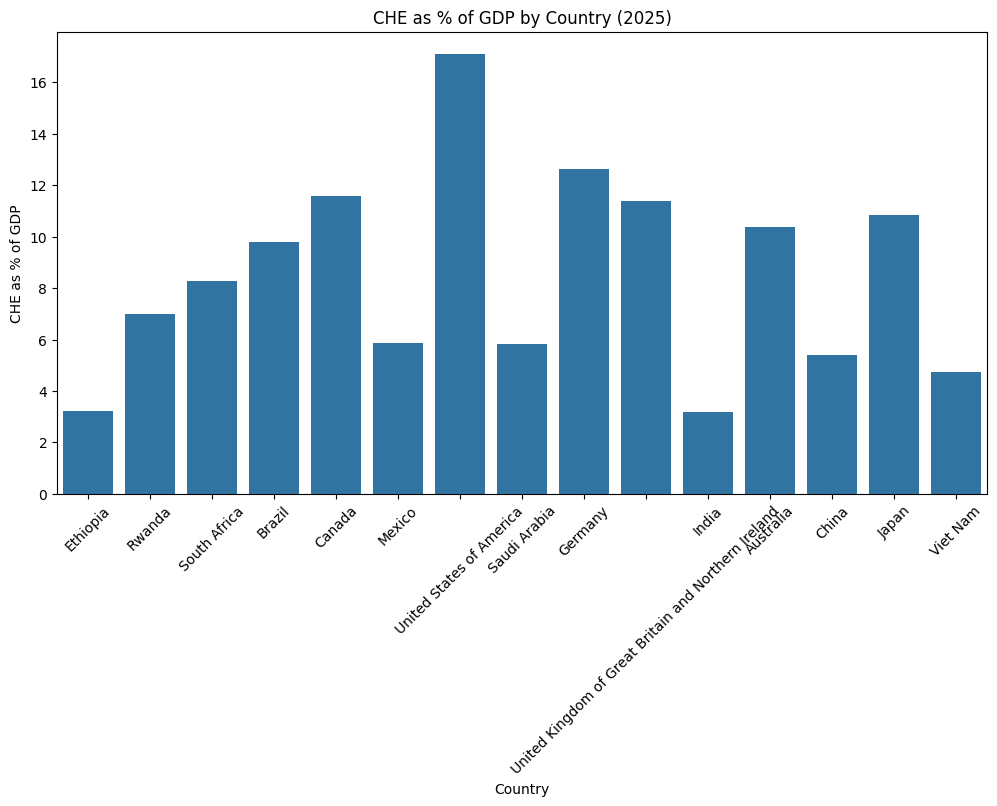

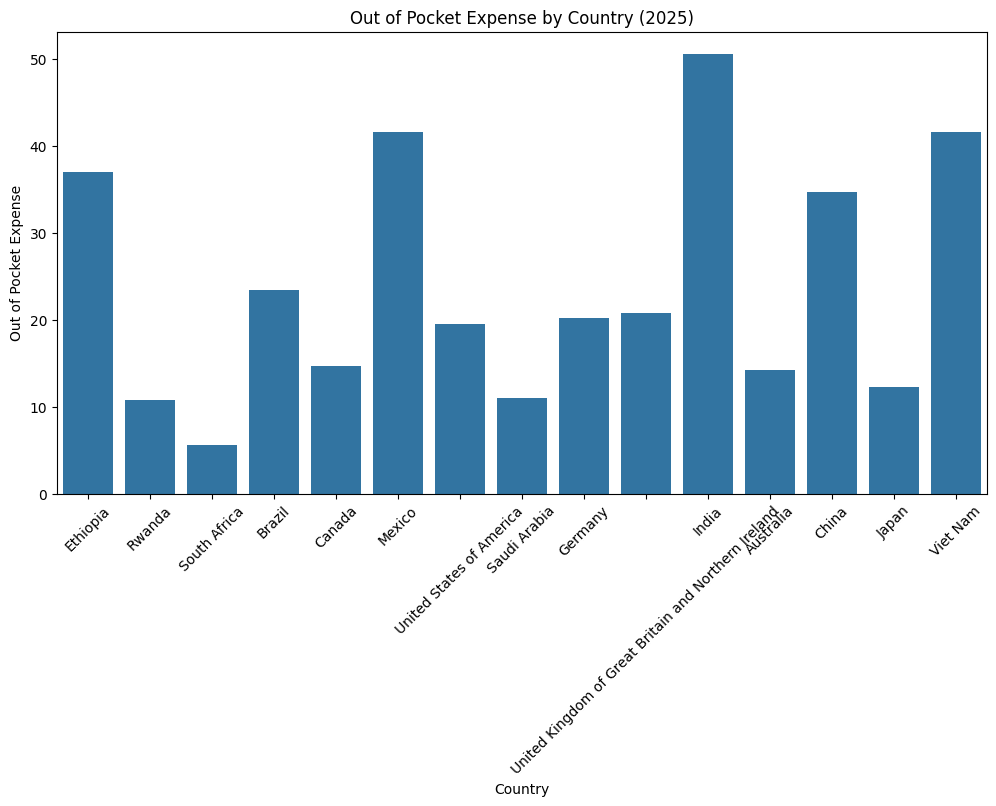

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for che_gdp
plt.figure(figsize=(12, 6))
sns.barplot(data=all_predictions, x='Country', y='che_gdp')
plt.title('CHE as % of GDP by Country (2025)')
plt.xlabel('Country')
plt.ylabel('CHE as % of GDP')
plt.xticks(rotation=45)
plt.show()

# Bar plot for Out of Pocket Expense
plt.figure(figsize=(12, 6))
sns.barplot(data=all_predictions, x='Country', y='Out of Pocket Expense ')
plt.title('Out of Pocket Expense by Country (2025)')
plt.xlabel('Country')
plt.ylabel('Out of Pocket Expense')
plt.xticks(rotation=45)
plt.show()

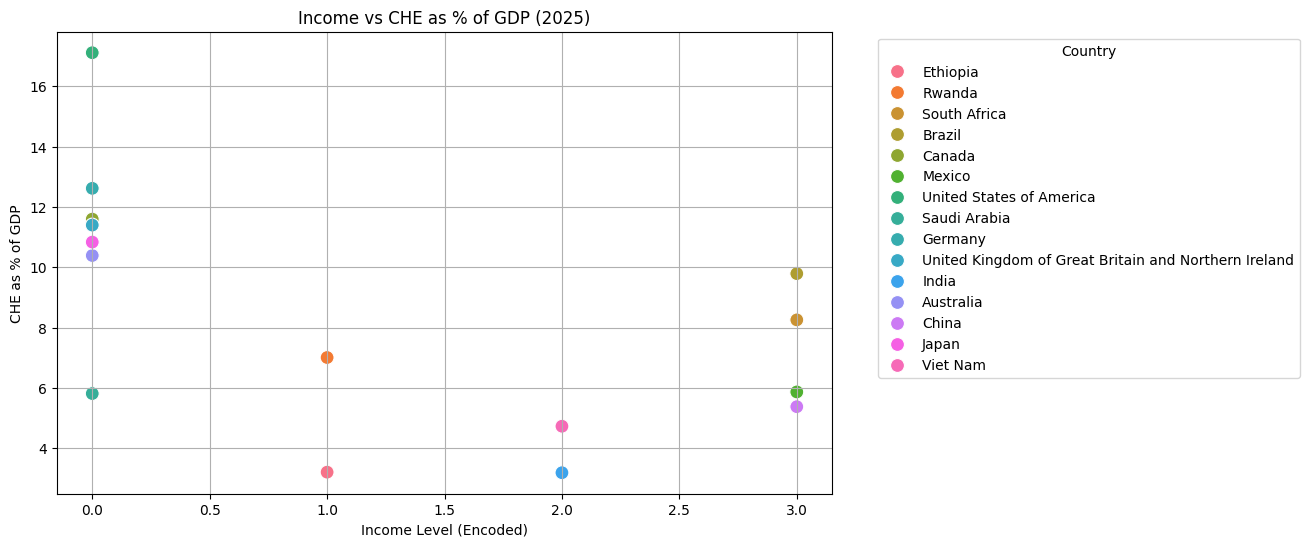

In [ ]:
# Scatter plot for Income vs CHE as % of GDP
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_predictions, x='Income_Encoded', y='che_gdp', hue='Country', s=100)
plt.title('Income vs CHE as % of GDP (2025)')
plt.xlabel('Income Level (Encoded)')
plt.ylabel('CHE as % of GDP')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

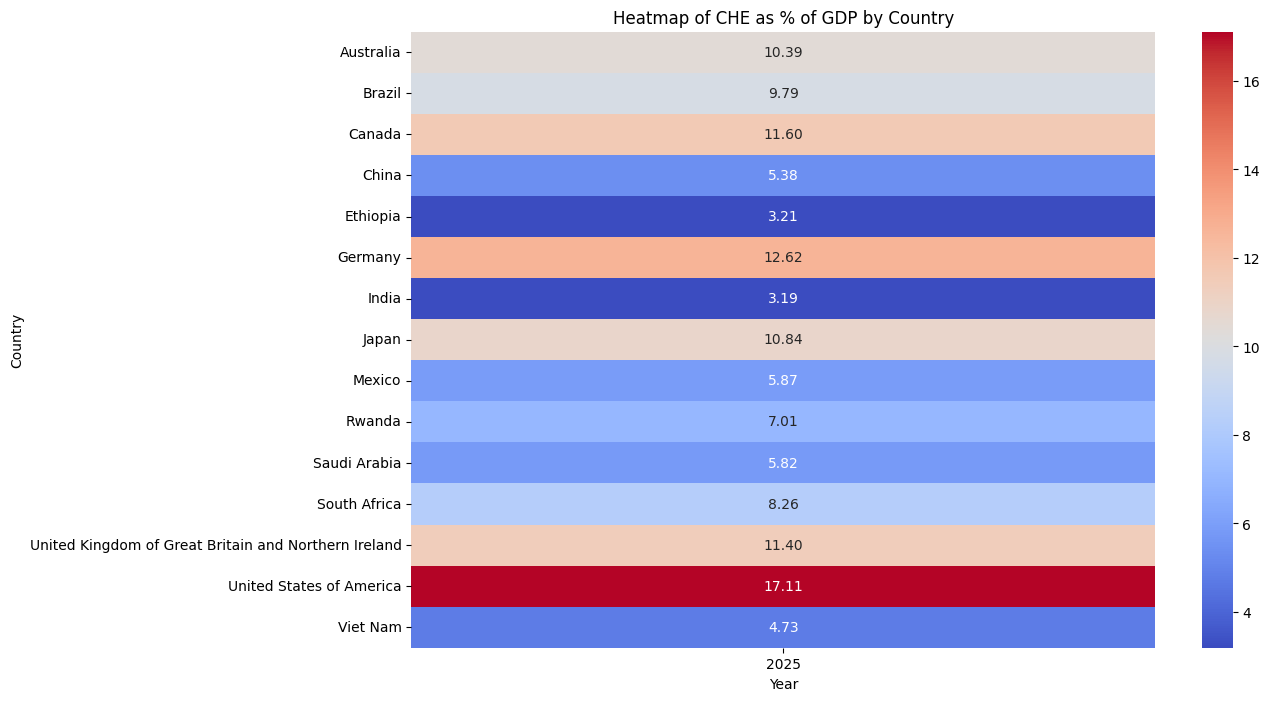

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot data for heatmap
che_gdp_pivot = all_predictions.pivot(index="Country", columns="Year", values="che_gdp")

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(che_gdp_pivot, cmap="coolwarm", annot=True, fmt=".2f")
plt.title('Heatmap of CHE as % of GDP by Country')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

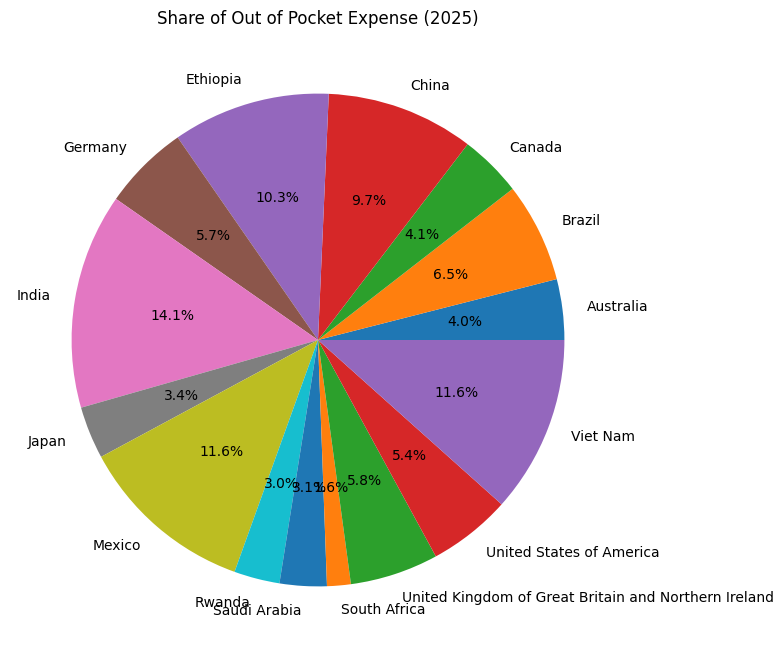

In [ ]:
# Pie chart for Out of Pocket Expense
plt.figure(figsize=(8, 8))
all_predictions.groupby('Country')['Out of Pocket Expense '].sum().plot.pie(autopct='%1.1f%%')
plt.title('Share of Out of Pocket Expense (2025)')
plt.ylabel('')
plt.show()

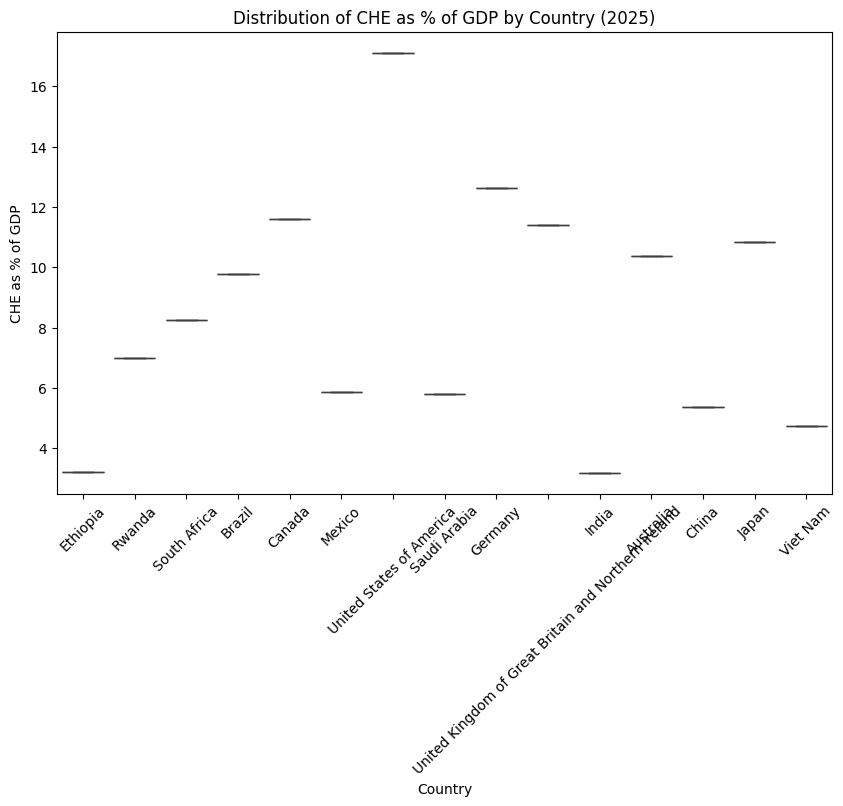

In [ ]:
# Box plot for CHE as % of GDP
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_predictions, x='Country', y='che_gdp')
plt.title('Distribution of CHE as % of GDP by Country (2025)')
plt.xlabel('Country')
plt.ylabel('CHE as % of GDP')
plt.xticks(rotation=45)
plt.show()

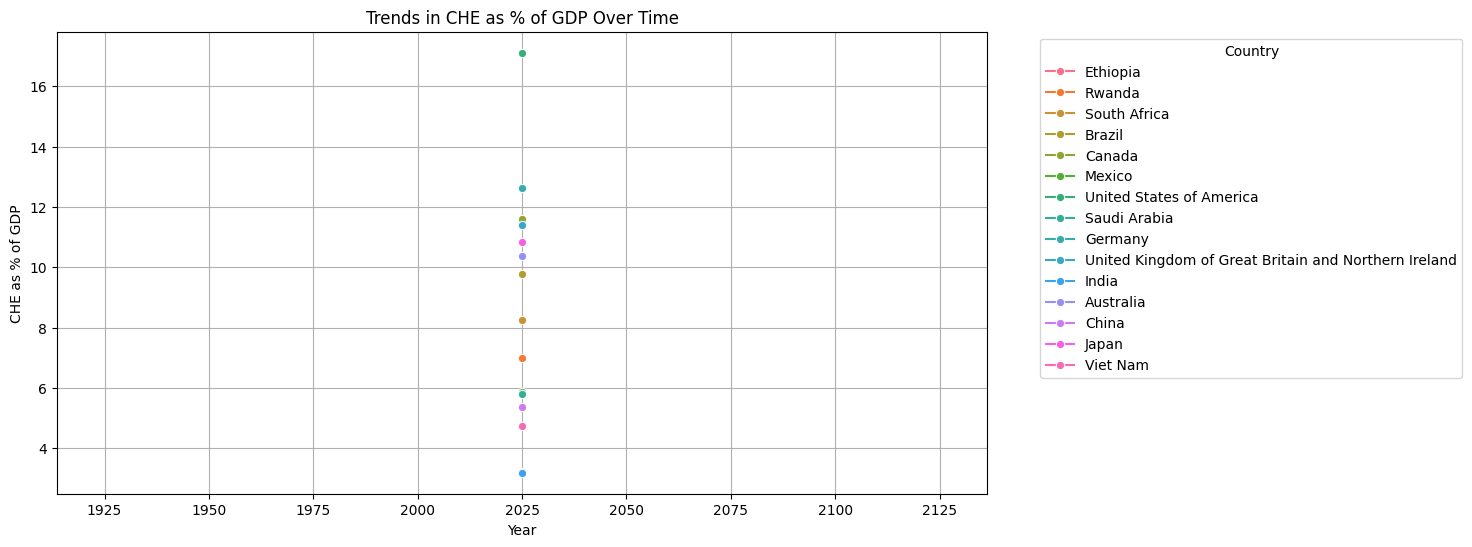

In [ ]:
# Line plot for CHE as % of GDP
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_predictions, x='Year', y='che_gdp', hue='Country', marker='o')
plt.title('Trends in CHE as % of GDP Over Time')
plt.xlabel('Year')
plt.ylabel('CHE as % of GDP')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

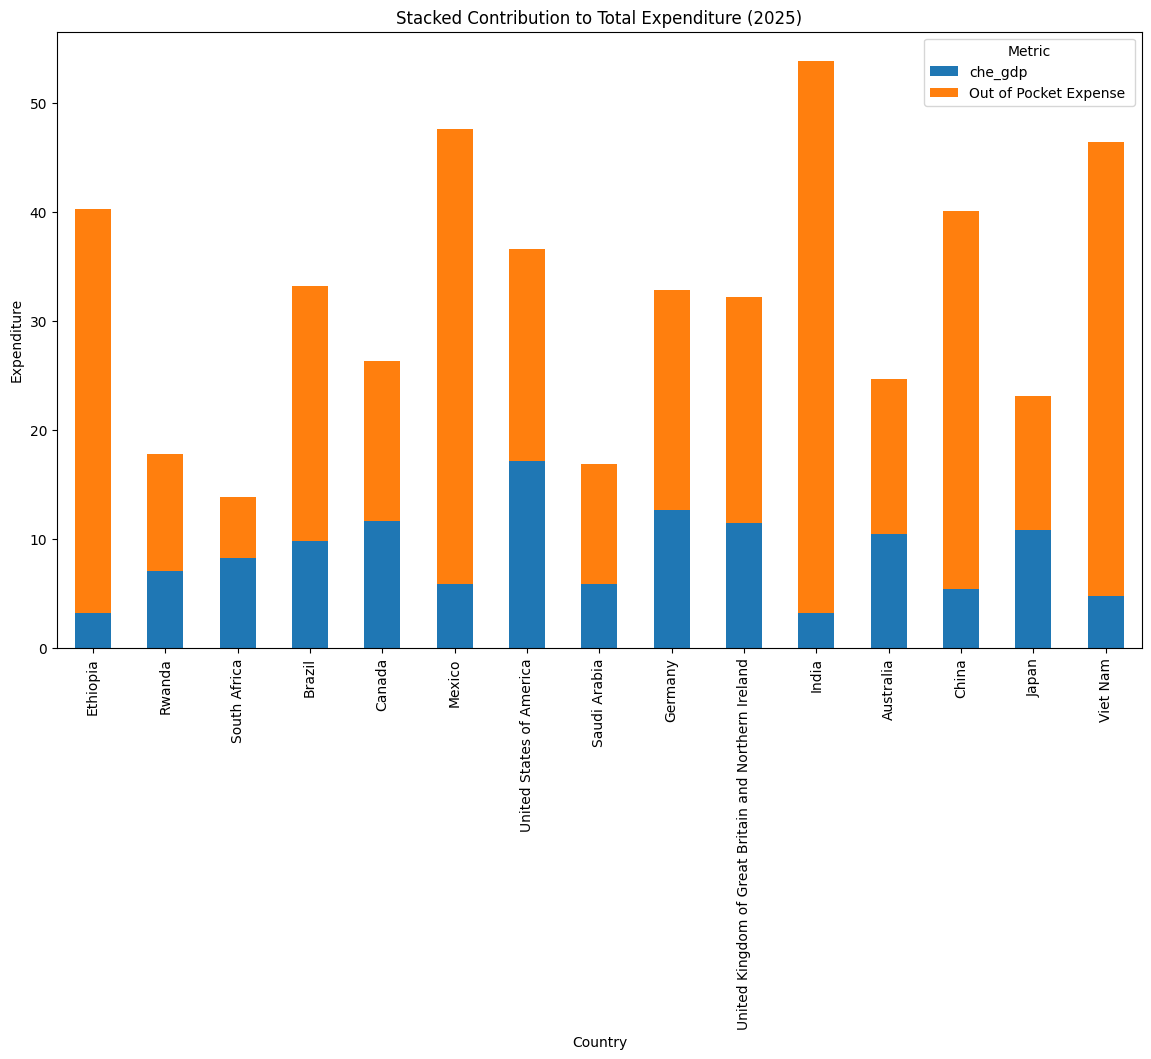

In [ ]:
all_predictions['Total_Expenditure'] = all_predictions['che_gdp'] + all_predictions['Out of Pocket Expense ']
all_predictions.plot(kind='bar', stacked=True, figsize=(14, 8), x='Country', y=['che_gdp', 'Out of Pocket Expense '])
plt.title('Stacked Contribution to Total Expenditure (2025)')
plt.xlabel('Country')
plt.ylabel('Expenditure')
plt.legend(title='Metric')
plt.show()

In [ ]:
from google.colab import files
files.download("Future_Predictions_For_2025.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
pip install geopandas matplotlib

In [11]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/Preprocessed_GHED.xlsx"  # Update this to match your file's location

Mounted at /content/drive


In [16]:
import pandas as pd
import plotly.express as px

# Example dataset with countries and their income categories
data = {
    "Country": [
        "Ethiopia", "Rwanda", "South Africa", "Brazil", "Canada",
        "United States of America", "India", "China", "Germany",
        "United Kingdom of Great Britain and Northern Ireland", "Japan", "Viet Nam"
    ],
    "Income_Level": [
        "Low", "Low", "Upper-middle", "Upper-middle", "High",
        "High", "Lower-middle", "Upper-middle", "High",
        "High", "High", "Lower-middle"
    ]
}

df = pd.DataFrame(data)

# Use Plotly to create a choropleth map
fig = px.choropleth(
    df,
    locations="Country",  # Column containing country names
    locationmode="country names",  # Match the country names
    color="Income_Level",  # Column to define the color
    title="World Map of Income Levels",
    color_discrete_map={
        "Low": "red",
        "Lower-middle": "orange",
        "Upper-middle": "blue",
        "High": "green"
    }
)

fig.update_geos(showcoastlines=True, coastlinecolor="Black")
fig.show()